In [1]:
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
def display_imgs(epoch, gen_loss, crit_loss, imgs, size=(1, 28, 28)):
    print(f'After {epoch} epochs')
    plt.plot(range(len(gen_loss)), gen_loss, label='Generator loss')
    plt.plot(range(len(crit_loss)), crit_loss, label='Critic loss')
    plt.legend()
    plt.show()
    
    img_unflat = imgs.detach().cpu().view(-1, *size)
    img_grid = make_grid(img_unflat[:25], nrow=5)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

# Generator

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, img_chan=1, h_dim=64, device='cpu'):
        super(Generator, self).__init__()
        
        self.z_dim = z_dim
        self.device = device
        self.gen = nn.Sequential(
            self.layer(z_dim, h_dim*4),
            self.layer(h_dim*4, h_dim*2, kernel_size=4, stride=1),
            self.layer(h_dim*2, h_dim),
            self.layer(h_dim, img_chan, kernel_size=4, last_layer=True)
        )

    def layer(self, in_dim, out_dim, kernel_size=3, stride=2, last_layer=False):
        if not last_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_dim, out_dim, kernel_size, stride),
                nn.BatchNorm2d(out_dim),
                nn.ReLU(),
            )
        return nn.Sequential(
            nn.ConvTranspose2d(in_dim, out_dim, kernel_size, stride),
            nn.Tanh(),
        )
    
    def get_loss(self, real_pred, fake_pred):
        loss = torch.abs(torch.mean(fake_pred) - torch.mean(real_pred))
        return loss
        
    def forward(self, noise):
        noise = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(noise)
    
    def get_imgs(self, n_imgs):
        noise = self.get_noise(n_imgs)
        return self(noise)
        
    def get_noise(self, n_samples):
        return torch.randn(n_samples, self.z_dim, device=self.device)

# Critic

In [4]:
class Critic(nn.Module):
    def __init__(self, img_chan=1, h_dim=16, device='cpu'):
        super(Critic, self).__init__()

        self.device = device
        self.crit = nn.Sequential(
            self.layer(img_chan, h_dim),
            self.layer(h_dim, h_dim*2),
            self.layer(h_dim*2, 1, last_layer=True),
        )
        
    def get_gradient(self, real_img, fake_img, epsilon):
        mixed_img = epsilon*real_img + (1-epsilon)*fake_img
        score = self(mixed_img)

        gradient = torch.autograd.grad(
            inputs=mixed_img,
            outputs=score,
            grad_outputs=torch.ones_like(score),
            create_graph=True,
            retain_graph=True,
        )[0]

        return gradient

    def get_gradient_panelty(self, real_img, fake_img):
        epsilon = torch.rand(len(real_img), 1, 1, 1, device=self.device, requires_grad=True)
        
        gradient = self.get_gradient(real_img, fake_img, epsilon)
        gradient = gradient.view(len(gradient), -1)
        gradient_norm = gradient.norm(2, dim=1)
        panelty = torch.mean((gradient_norm - 1) ** 2)
        
        return panelty
    
    def get_loss(self, real_pred, fake_pred, c_lambda, gp):
        loss = 1/torch.abs(torch.mean(fake_pred) - torch.mean(real_pred)) + c_lambda*gp
        return loss

    def layer(self, in_dim, out_dim, kernel_size=4, stride=2, last_layer=False):
        if not last_layer:
            return nn.Sequential(
                nn.Conv2d(in_dim, out_dim, kernel_size, stride),
                nn.BatchNorm2d(out_dim),
                nn.LeakyReLU(negative_slope=0.2),
            )
        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size, stride),
        )

    def forward(self, img):
        crit_pred = self.crit(img)
        return crit_pred.view(len(crit_pred), -1)

# Data Loading & Initialization

In [5]:
Z_DIM=64
BATCH_SIZE=128
BETAS=(0.5, 0.999)
LR=0.0002
C_LAMBDA=10
N_EPOCHS=50
DISPLAY_STEP=5
DEVICE='cuda'

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=BATCH_SIZE,
    shuffle=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [7]:
gen = Generator(Z_DIM, device=DEVICE).to(DEVICE)
crit = Critic(device=DEVICE).to(DEVICE)
gen_opt = torch.optim.Adam(gen.parameters(), lr=LR, betas=BETAS)
crit_opt = torch.optim.Adam(crit.parameters(), lr=LR, betas=BETAS)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

# Training

In [8]:
no_of_batches = len(dataloader)
crit_repeat = 5
crit_losses = []
gen_losses = []

  0%|          | 0/50 [00:00<?, ?it/s]

After 0 epochs


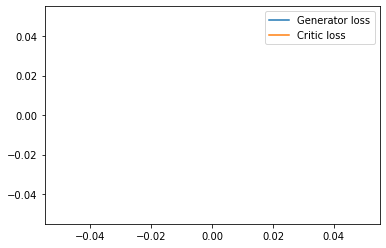

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


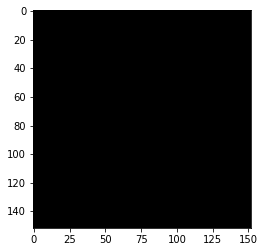

After 0 epochs


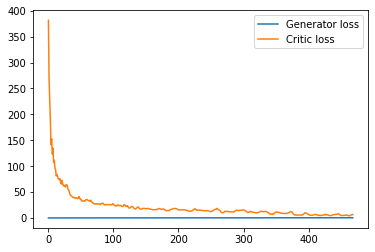

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


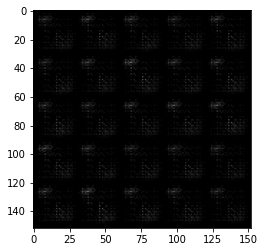

After 5 epochs


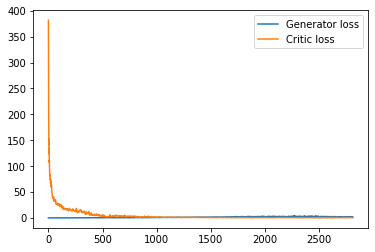

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


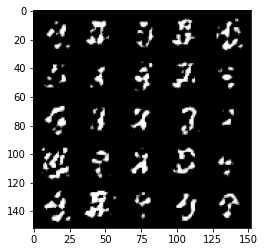

After 10 epochs


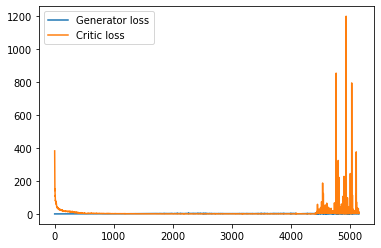

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


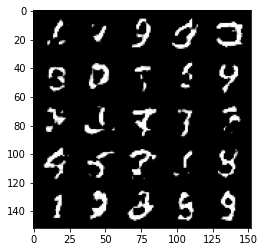

After 15 epochs


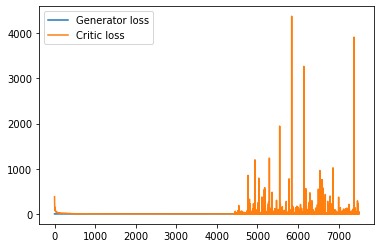

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


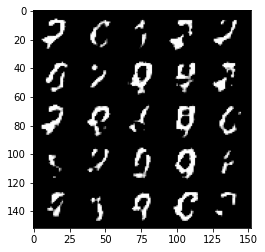

After 20 epochs


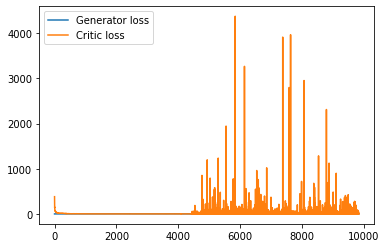

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


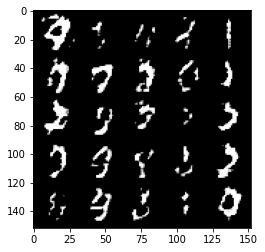

After 25 epochs


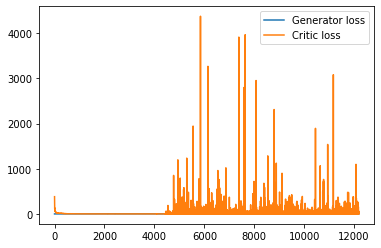

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


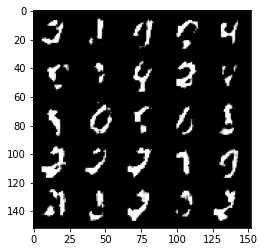

KeyboardInterrupt: ignored

In [9]:
tqdm_obj = tqdm(range(0, N_EPOCHS))
display_imgs(0, gen_losses, crit_losses, gen.get_imgs(25), size=(1, 28, 28))

for epoch in tqdm_obj:
    if epoch == 30:
        crit_repeat = 1

    for i, (imgs_real, _) in enumerate(dataloader, 0):
        tqdm_obj.set_postfix({ 'Batch': f'{i}/{no_of_batches}' })
        cur_batch_size = len(imgs_real)
        imgs_real = imgs_real.to(DEVICE)

        # Critic traning
        crit_mean_iteration_loss = 0
        for _ in range(crit_repeat):
            crit_opt.zero_grad()
            #Forward pass
            imgs_fake = gen.get_imgs(cur_batch_size)
            pred_fake = crit(imgs_fake.detach())
            pred_real = crit(imgs_real)
            # Backward pass
            gp = crit.get_gradient_panelty(imgs_real, imgs_fake)
            crit_loss = crit.get_loss(pred_real, pred_fake, C_LAMBDA, gp)
            crit_loss.backward(retain_graph=True)
            crit_opt.step()
            
            crit_mean_iteration_loss += crit_loss.cpu().detach().numpy()
        crit_losses.append(crit_mean_iteration_loss / crit_repeat)

        # Generator training
        gen_opt.zero_grad()
        # Forward pass
        imgs_fake = gen.get_imgs(cur_batch_size)
        pred_fake = crit(imgs_fake)
        pred_real = crit(imgs_real)
        # Backward pass
        gen_loss = gen.get_loss(pred_real, pred_fake)
        gen_loss.backward()
        gen_opt.step()
        
        gen_losses.append(gen_loss.cpu().detach().numpy())

    if epoch % DISPLAY_STEP == 0:
        display_imgs(epoch, gen_losses, crit_losses, gen.get_imgs(25), size=(1, 28, 28))

  0%|          | 0/50 [00:00<?, ?it/s]

After 0 epochs


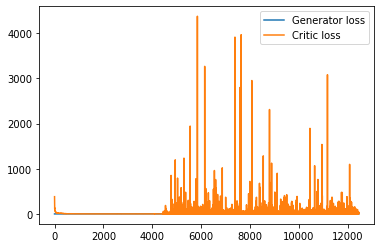

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


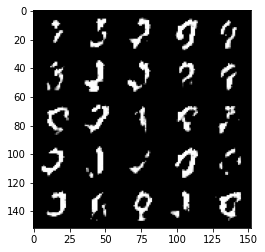

After 0 epochs


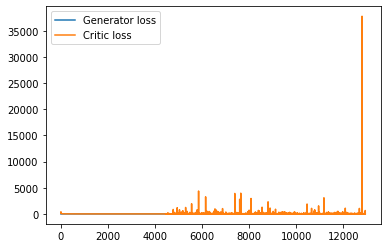

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


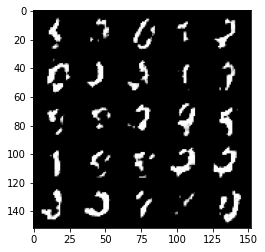

After 5 epochs


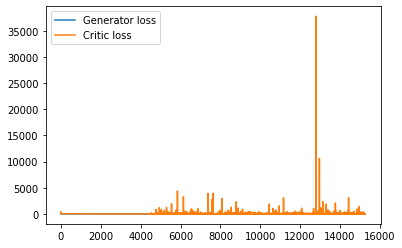

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


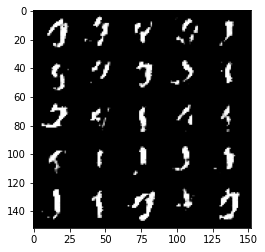

After 10 epochs


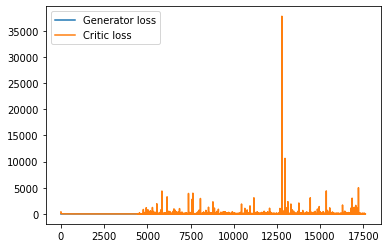

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


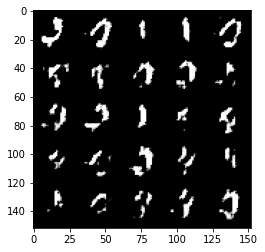

After 15 epochs


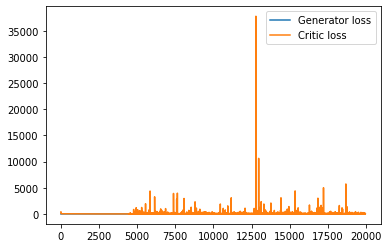

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


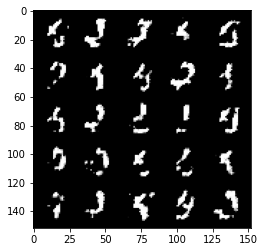

After 20 epochs


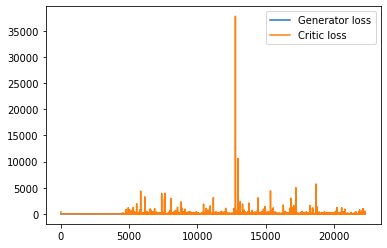

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


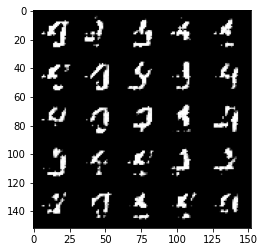

After 25 epochs


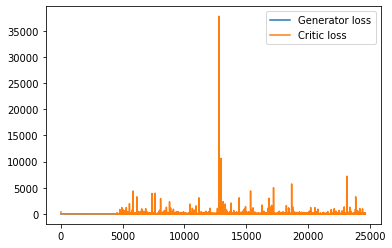

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


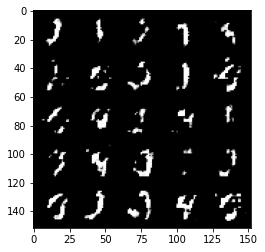

After 30 epochs


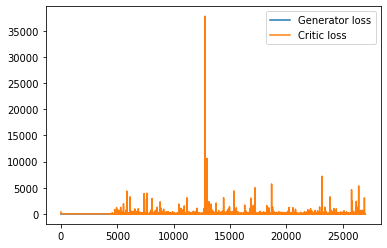

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


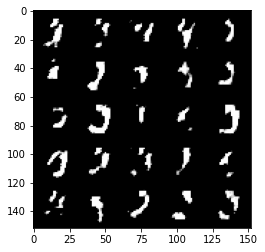

After 35 epochs


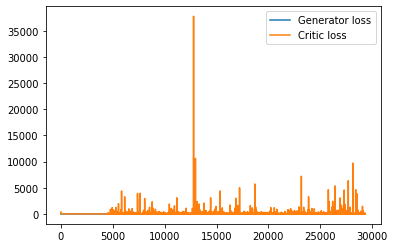

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


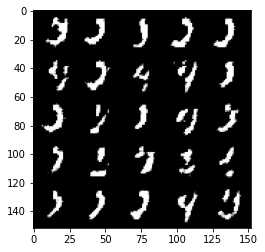

After 40 epochs


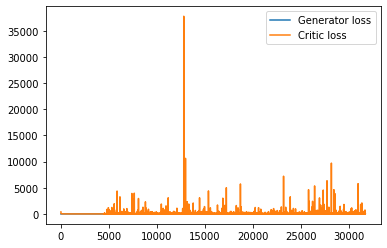

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


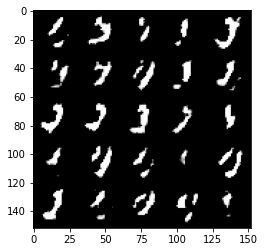

After 45 epochs


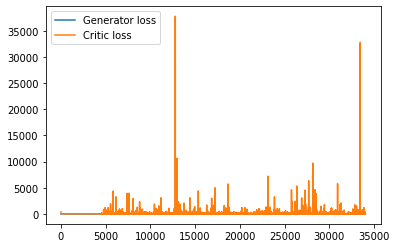

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


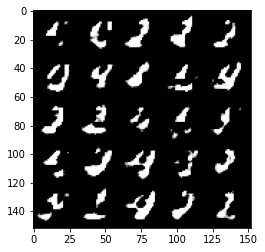

In [10]:
EPOCHS = 0
tqdm_obj = tqdm(range(0, N_EPOCHS))
display_imgs(0, gen_losses, crit_losses, gen.get_imgs(25), size=(1, 28, 28))

for epoch in tqdm_obj:
    if epoch == 30:
        crit_repeat = 1

    for i, (imgs_real, _) in enumerate(dataloader, 0):
        tqdm_obj.set_postfix({ 'Batch': f'{i}/{no_of_batches}' })
        cur_batch_size = len(imgs_real)
        imgs_real = imgs_real.to(DEVICE)

        # Critic traning
        crit_mean_iteration_loss = 0
        for _ in range(crit_repeat):
            crit_opt.zero_grad()
            #Forward pass
            imgs_fake = gen.get_imgs(cur_batch_size)
            pred_fake = crit(imgs_fake.detach())
            pred_real = crit(imgs_real)
            # Backward pass
            gp = crit.get_gradient_panelty(imgs_real, imgs_fake)
            crit_loss = crit.get_loss(pred_real, pred_fake, C_LAMBDA, gp)
            crit_loss.backward(retain_graph=True)
            crit_opt.step()
            
            crit_mean_iteration_loss += crit_loss.cpu().detach().numpy()
        crit_losses.append(crit_mean_iteration_loss / crit_repeat)

        # Generator training
        gen_opt.zero_grad()
        # Forward pass
        imgs_fake = gen.get_imgs(cur_batch_size)
        pred_fake = crit(imgs_fake)
        pred_real = crit(imgs_real)
        # Backward pass
        gen_loss = gen.get_loss(pred_real, pred_fake)
        gen_loss.backward()
        gen_opt.step()
        
        gen_losses.append(gen_loss.cpu().detach().numpy())

    if epoch % DISPLAY_STEP == 0:
        display_imgs(epoch, gen_losses, crit_losses, gen.get_imgs(25), size=(1, 28, 28))